In [212]:
import pandas as pd
from data_scientist import load_hist_df,get_key_value,get_dist
import matplotlib.pyplot as plt
from collections import Counter

In [125]:
df_clu = pd.read_csv("clusters_histogram.csv")
df_clu.head()

,ID,hist
0,1,[{'k': 'eventCategory=Management\teventName=Ge...
1,2,[{'k': 'eventCategory=Management\teventName=Ge...
2,3,[{'k': 'eventCategory=Management\teventName=Ge...
3,4,[{'k': 'errorCode=UserNotFoundException\tevent...
4,5,[{'k': 'eventCategory=Data\teventName=CopyObje...


In [126]:
df_clu.describe()

,ID
count,112.000000
mean,56.500000
std,32.475632
min,1.000000
25%,28.750000
50%,56.500000
75%,84.250000
max,112.000000


In [127]:
df_ses = pd.read_csv("sessions_histogram.csv")
df_ses.head()

,ID,hist
0,SPSSN4478549194297154363,[{'k': 'errorCode=ObjectLockConfigurationNotFo...
1,SPSSNm6890555198667692826,[{'k': 'eventCategory=Management\teventName=Li...
2,SPSSNm4080651934773293128,[{'k': 'eventCategory=Management\teventName=Ge...
3,SPSSN6871687774071215214,[{'k': 'eventCategory=Management\teventName=Ge...
4,SPSSN3119038093632912926,[{'k': 'eventCategory=Management\teventName=Ge...


In [128]:
df_ses.describe()

,ID,hist
count,119,119
unique,119,117
top,SPSSN4478549194297154363,[{'k': 'errorCode=AccessDenied\teventCategory=...
freq,1,3


In [129]:
ses_dict = load_hist_df(df_ses)
clu_dict = load_hist_df(df_clu)

In [130]:
# Fisrt problem - even as users/clusters are intersecting, the dsitances are still quite close to 1.
# Check the distribution of the costs - is it similar across clusters? is it similar across sessions? perhaps it is not normalized
# verify that same actions have the same costs

In [131]:
# Questions:
# What are the cost values? What do they repesent? How they are set? costs? clicks?

In [224]:
def get_costs_from_dict(target_dict):
    c_sums = []
    for cluster_ind,actions in target_dict.items():
        c_sum = 0
        for action in actions:
            c_sum += action['c']
        c_sums.append(c_sum)
    return c_sums

In [225]:
c_sums = get_costs_from_dict(clu_dict)
s_sums = get_costs_from_dict(ses_dict)

In [226]:
s_sums_filtered =list(filter(lambda x: 0<x and x<100, s_sums))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


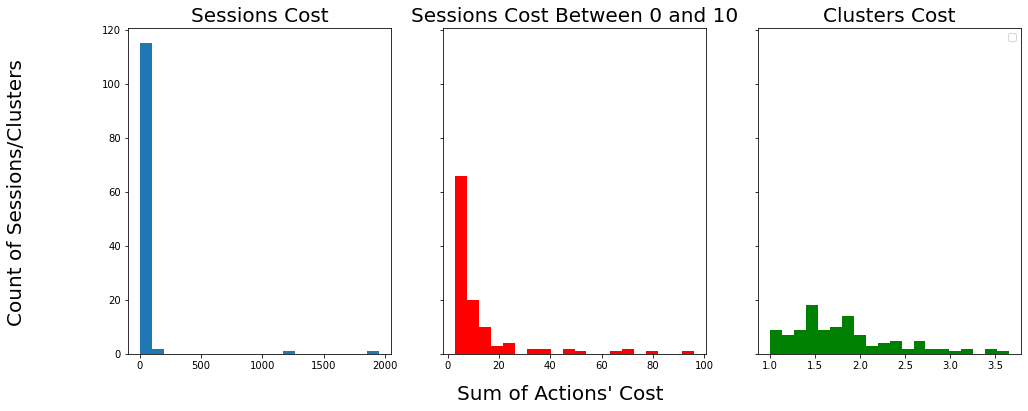

In [227]:
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(16, 6))
axes[0].hist(s_sums,bins=20)
axes[1].hist(s_sums_filtered,bins=20,color='red')
axes[2].hist(c_sums,bins=20,color = 'green')
axes[0].set_title('Sessions Cost',size=20)
axes[1].set_title('Sessions Cost Between 0 and 10',size=20)
axes[2].set_title('Clusters Cost',size=20)
fig.supylabel('Count of Sessions/Clusters',size=20)
fig.supxlabel("Sum of Actions' Cost",size=20)
plt.legend(loc='upper right')

In [136]:
# The two distributions of costs of the sessions and the clusters seem quite different
# one should first get rid of outliers, for example by setting some maximum value to the sessions, and then normalize them both to the same space

In [137]:
# Let's examine the actions abit more, and find ones which action's cost is abnormal

In [187]:
actions_values = {}
for k in ses_dict.keys():
    for hist in ses_dict.get(k):
        actions_values[hist['k']] = hist['c']

In [188]:
values_only = list(actions_values.values())
values_only.sort()

In [204]:
outlier_value = 100

In [205]:
outlier_actions = list(set([k for k,v in actions_values.items() if v > outlier_value]))

In [206]:
len(outlier_actions)

10

In [228]:
outlier_actions

['eventCategory=Management\teventName=ListImages\teventSource=ecr.amazonaws.com\teventType=AwsApiCall\treadOnly=True\trecipientAccountId=333333333333\trequestParameters_repositoryName=trackerdetect/trackeriq-job\tuserIdentity_accountId=333333333333\tuserIdentity_sessionContext_attributes_mfaAuthenticated=false\t',
 'errorCode=EntityNotFoundException\teventCategory=Management\teventName=DeleteTable\teventSource=glue.amazonaws.com\teventType=AwsApiCall\treadOnly=False\trecipientAccountId=333333333333\tuserIdentity_accountId=333333333333\tuserIdentity_sessionContext_attributes_mfaAuthenticated=false\t',
 'eventCategory=Management\teventName=ListImages\teventSource=ecr.amazonaws.com\teventType=AwsApiCall\treadOnly=True\trecipientAccountId=333333333333\trequestParameters_repositoryName=trackerdetect/trackeriq-audit\tuserIdentity_accountId=333333333333\tuserIdentity_sessionContext_attributes_mfaAuthenticated=false\t',
 'eventCategory=Management\teventName=ListImages\teventSource=ecr.amazonaw

In [193]:
# Let's find key-value pairs that are highly correlated with these abnormal values

In [209]:
total_ses_dist = get_dist(ses_dict)

In [215]:
total_ses_dist

{'errorCode': Counter({'ObjectLockConfigurationNotFoundError': 11,
          'NoSuchKey': 8,
          'NoSuchPublicAccessBlockConfiguration': 19,
          'NoSuchBucketPolicy': 15,
          'AccessDenied': 76,
          'OwnershipControlsNotFoundError': 9,
          'NoSuchWebsiteConfiguration': 4,
          'InvalidAccessException': 16,
          'ResourceNotFoundException': 15,
          'OptInRequiredException': 2,
          'ValidationException': 4,
          'RequestTimeout': 3,
          'Client.InvalidID': 1,
          'Client.MissingParameter': 1,
          'ServerSideEncryptionConfigurationNotFoundError': 2,
          'NotFoundException': 2,
          'InvalidInputException': 3,
          'IncompleteBody': 1,
          'InvalidRequestException': 1,
          'ForbiddenException': 1,
          'UserNotFoundException': 3,
          'InvalidPasswordException': 1,
          'InvalidParameterException': 4,
          'Client.InvalidParameterValue': 1,
          'InternalFailure':

In [213]:
outliers_dist = {}
for i in range(len(outlier_actions)):
    pairs = get_key_value({'k':outlier_actions[i]})
    for k1, v in pairs.items():
        c = outliers_dist.get(k1)
        if c:
            c.update({v: 1})
        else:
            outliers_dist[k1] = Counter({v: 1})

In [214]:
outliers_dist

{'eventCategory': Counter({'Management': 10}),
 'eventName': Counter({'ListImages': 8, 'DeleteTable': 2}),
 'eventSource': Counter({'ecr.amazonaws.com': 8, 'glue.amazonaws.com': 2}),
 'eventType': Counter({'AwsApiCall': 10}),
 'readOnly': Counter({'True': 8, 'False': 2}),
 'recipientAccountId': Counter({'333333333333': 10}),
 'requestParameters_repositoryName': Counter({'trackerdetect/trackeriq-job': 1,
          'trackerdetect/trackeriq-audit': 1,
          'trackerdetect/trackeriq-db': 1,
          'trackerdetect/trackeriq-scheduler': 1,
          'trackerdetect/trackeriq-frontend': 1,
          'trackerdetect/trackeriq-acm': 1,
          'trackerdetect/trackeriq-backoffice': 1,
          'trackerdetect/trackeriq-analysis-model': 1}),
 'userIdentity_accountId': Counter({'333333333333': 10}),
 'userIdentity_sessionContext_attributes_mfaAuthenticated': Counter({'false': 10}),
 'errorCode': Counter({'EntityNotFoundException': 1})}

In [229]:
actions_to_correlation = {}
for key,counter in outliers_dist.items():
    for parameter in counter.keys():
        actions_to_correlation[key + '_' + parameter] = counter[parameter]/total_ses_dist[key][parameter]

In [230]:
actions_to_correlation

{'eventCategory_Management': 0.013927576601671309,
 'eventName_ListImages': 1.0,
 'eventName_DeleteTable': 0.3333333333333333,
 'eventSource_ecr.amazonaws.com': 0.17391304347826086,
 'eventSource_glue.amazonaws.com': 0.020202020202020204,
 'eventType_AwsApiCall': 0.012836970474967908,
 'readOnly_True': 0.011251758087201125,
 'readOnly_False': 0.025,
 'recipientAccountId_333333333333': 0.012642225031605562,
 'requestParameters_repositoryName_trackerdetect/trackeriq-job': 0.25,
 'requestParameters_repositoryName_trackerdetect/trackeriq-audit': 0.25,
 'requestParameters_repositoryName_trackerdetect/trackeriq-db': 0.25,
 'requestParameters_repositoryName_trackerdetect/trackeriq-scheduler': 0.2,
 'requestParameters_repositoryName_trackerdetect/trackeriq-frontend': 0.25,
 'requestParameters_repositoryName_trackerdetect/trackeriq-acm': 0.16666666666666666,
 'requestParameters_repositoryName_trackerdetect/trackeriq-backoffice': 0.25,
 'requestParameters_repositoryName_trackerdetect/trackeriq-a

In [223]:
max_parameter = max(actions_to_correlation, key=actions_to_correlation.get)
max_parameter,actions_to_correlation[max_parameter]

('ListImages', 1.0)

In [ ]:
# Second problem - not many users/clusters are intersecting
## I can inspect the histogram of the sizes of different sessions and clusters
## also the histogram of the hard intersection between sessions and clusters
# perhaps consider some sort of soft intersection - I can check to see if the action itself does not overlap, if still some of the fields overlap - as a soft measure
# histogram of intersection between actions
# futuristic - develop a dense embedding mechanism that embeds actions that appears together simiarly. Then the session is the average sum of the embeddings.